# Testing Dataset: ./test_JHTDB/channel_x1_64_y256_z1_64_t1000.h5


In [1]:
import scipy.io as sio
import h5py
import time
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
# See https://stackoverflow.com/a/10472712 for autoreload
from frequentDirections import FrequentDirections
from rSVDsp import *
# ! Load testing channel flow

Ux_reshape = load_JHTDB_data() # Defaults: data_directory = '../test_JHTDB/', ntstep = 1000, nsample = 64, which_component = 'x'):
    
# ntstep = 1000
# nsample = 64

dimReduced = 100

blockSize = 100
m, n = np.shape(Ux_reshape)
nBlocks = np.ceil(n/blockSize).astype(int)

# exact SVD: Compress entire matrix

In [2]:
t_start = time.time()
U_ux_rsvd, S_ux_rsvd ,V_ux_rsvd = truncateSVD(Ux_reshape, dimReduced)
S_ux_rsvd_mat = np.zeros((dimReduced, dimReduced))
np.fill_diagonal(S_ux_rsvd_mat,S_ux_rsvd)
Ux_recon_rsvd = U_ux_rsvd @ S_ux_rsvd_mat @ V_ux_rsvd
t_end = time.time()
norm_f = np.linalg.norm(Ux_reshape-Ux_recon_rsvd,'fro')/np.linalg.norm(Ux_reshape,'fro')
print('Truncated SVD:{0:.3e} Time:{1:.2f} s'.format(norm_f, t_end-t_start))

Truncated SVD:1.057e-03 Time:3.00 s


# rSVDsp: Compress entire matrix

In [61]:
t_start = time.time()
U_ux_sp, S_ux_sp ,V_ux_sp = rSVDsp_unblock_streaming(Ux_reshape.T, dimReduced)
t_end = time.time()


S_ux_mat = np.zeros((dimReduced,dimReduced))
np.fill_diagonal(S_ux_mat, S_ux_sp)

Ux_recon_entire = np.transpose(U_ux_sp@S_ux_mat@V_ux_sp)
norm_f = np.linalg.norm(Ux_reshape-Ux_recon_entire,'fro')/np.linalg.norm(Ux_reshape,'fro')
print('rSVDsp streaming:{0:.3e} Time:{1:.2f} s'.format(norm_f, t_end-t_start))


blocksize_A = 8
t_start = time.time()
U_ux_sp, S_ux_sp ,V_ux_sp = rSVDsp_unblock_streaming(Ux_reshape.T, dimReduced, blocksize_A = blocksize_A)
t_end = time.time()

V = S_ux_sp.reshape((-1,1))*V_ux_sp
nrmA = np.linalg.norm(Ux_reshape.T,'fro')
norm_f = fastFrobeniusNorm(U_ux_sp,V,Ux_reshape.T, nrmA)/nrmA

print(f'Reading in the matrix {blocksize_A} rows at a time, the time is now {t_end-t_start:.2f} s, error {norm_f:.2e}')

rSVDsp streaming:1.997e-03 Time:1.40 s
Reading in the matrix 8 rows at a time, the time is now 0.19 s, error 1.97e-03


In [7]:
# Some profiling:
!pip install line_profiler
%load_ext line_profiler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 664.2 kB/s eta 0:00:0031m1.0 MB/s eta 0:00:01


In [50]:
# Testing code to be used for onepass_update
x = 'abcdefghijklmnopqrstuvwxyz'
m = 11
x = x[:m]
blockSize = 3
nBlocks = int( m / blockSize )
nBlocks
for j in range(nBlocks):
    print(  x[j*blockSize:(j+1)*blockSize]  )

if nBlocks*blockSize < m:
    # add the stragglers
    print(  x[nBlocks*blockSize:]  )

abc
def
ghi
jk


In [14]:
# The following code with run the c_sgd(... ) stuff, and the -f fcnName will tell it
# to do line-by-line profiling of that routine. So if c_sgd(...) calls another subroutine
#  like gradient(), then do %lprun -f gradient c_sgd(Ak,...) to see its breakdown
%lprun -f rSVDsp_unblock_streaming rSVDsp_unblock_streaming(Ux_reshape.T, dimReduced)

Timer unit: 1e-06 s

Total time: 1.33207 s
File: /Users/srbecker/Repos/ASCR_DataReduction/src/rSVDsp.py
Function: rSVDsp_unblock_streaming at line 162

Line #      Hits         Time  Per Hit   % Time  Line Contents
   162                                           def rSVDsp_unblock_streaming(A, k, rng = default_rng() ):
   163                                               """
   164                                               Description: Modified from the Single-pass Randomized Blocked SVD From Yu et al (2017)
   165                                               
   166                                               Notes: 1. Each row in the input matrix A represents the data from one time step
   167                                                      2. The matrix A is read row by row 
   168                                                      3. The SVD is performed in the un-block way
   169                                               """
   170         1         36.0     36.

# Adaptively update basis

In [81]:
blockSize_ini = 100
list_blockSize_add =[1,2,4,8,16,32,64]
blockSize_add = 1

for blockSize_add in list_blockSize_add:
    t_start = time.time()


    Ub, Sb, Vb = SVD_update_adaptive(Ux_reshape, dimReduced,blockSize_ini, blockSize_add)

    t_end = time.time()
    Sb_mat_update = np.zeros((dimReduced, dimReduced))
    np.fill_diagonal(Sb_mat_update, Sb)
    Ux_recon_col_update = Ub@Sb_mat_update@Vb
    norm_f = np.linalg.norm(Ux_reshape-Ux_recon_col_update,'fro')/np.linalg.norm(Ux_reshape,'fro')

    print('Blocked version (update basis {2} cols by cols):{0} Time:{1}'.format(norm_f,t_end-t_start, blockSize_add))

Blocked version (update basis 1 cols by cols):0.0032884051703354856 Time:3.8843445777893066
Blocked version (update basis 2 cols by cols):0.003906391242969261 Time:2.160740852355957
Blocked version (update basis 4 cols by cols):0.0019978015287767242 Time:1.1881318092346191
Blocked version (update basis 8 cols by cols):0.0012956681443032823 Time:0.7751896381378174
Blocked version (update basis 16 cols by cols):0.0010937214235029389 Time:0.542731523513794
Blocked version (update basis 32 cols by cols):0.0010808738398820493 Time:0.4807283878326416
Blocked version (update basis 64 cols by cols):0.0010721404995711757 Time:0.4462776184082031


# Frequent directions

In [82]:
#! Frequent directions (Use sketch once, two pass)

t_start = time.time()

n_row, n_col = np.shape(Ux_reshape)
sketcher = FrequentDirections(n_row, dimReduced)
for i in range(n_col):
    row = Ux_reshape[:,i].T
    sketcher.append(row)
sketch = sketcher.get()

[Q_fd_sketch, R_fd_sketch] = np.linalg.qr(sketch.T)
B_fd = Ux_reshape.T@Q_fd_sketch
U_fd, S_fd, V_fd = np.linalg.svd(B_fd, full_matrices=False)
V_fd = V_fd @ Q_fd_sketch.T
U_fd = U_fd[:, range(dimReduced)]
V_fd = V_fd[range(dimReduced), :]
S_fd = S_fd[range(dimReduced)]

S_fd_matrix = np.zeros((dimReduced,dimReduced))
np.fill_diagonal(S_fd_matrix,S_fd)
Ux_recon_fd = V_fd.T@S_fd_matrix@U_fd.T


# [_,s,Vt] = np.linalg.svd(sketch , full_matrices=False)
# Ux_recon_fd =Vt.T@Vt@Ux_reshape
t_end = time.time()

norm_f = np.linalg.norm(Ux_reshape-Ux_recon_fd,'fro')/np.linalg.norm(Ux_reshape,'fro')

print('Frequent directions:{0} Time:{1}'.format(norm_f,t_end-t_start))

Frequent directions:0.004246593703800927 Time:0.25957536697387695


# Plot Results

<Figure size 1440x360 with 0 Axes>

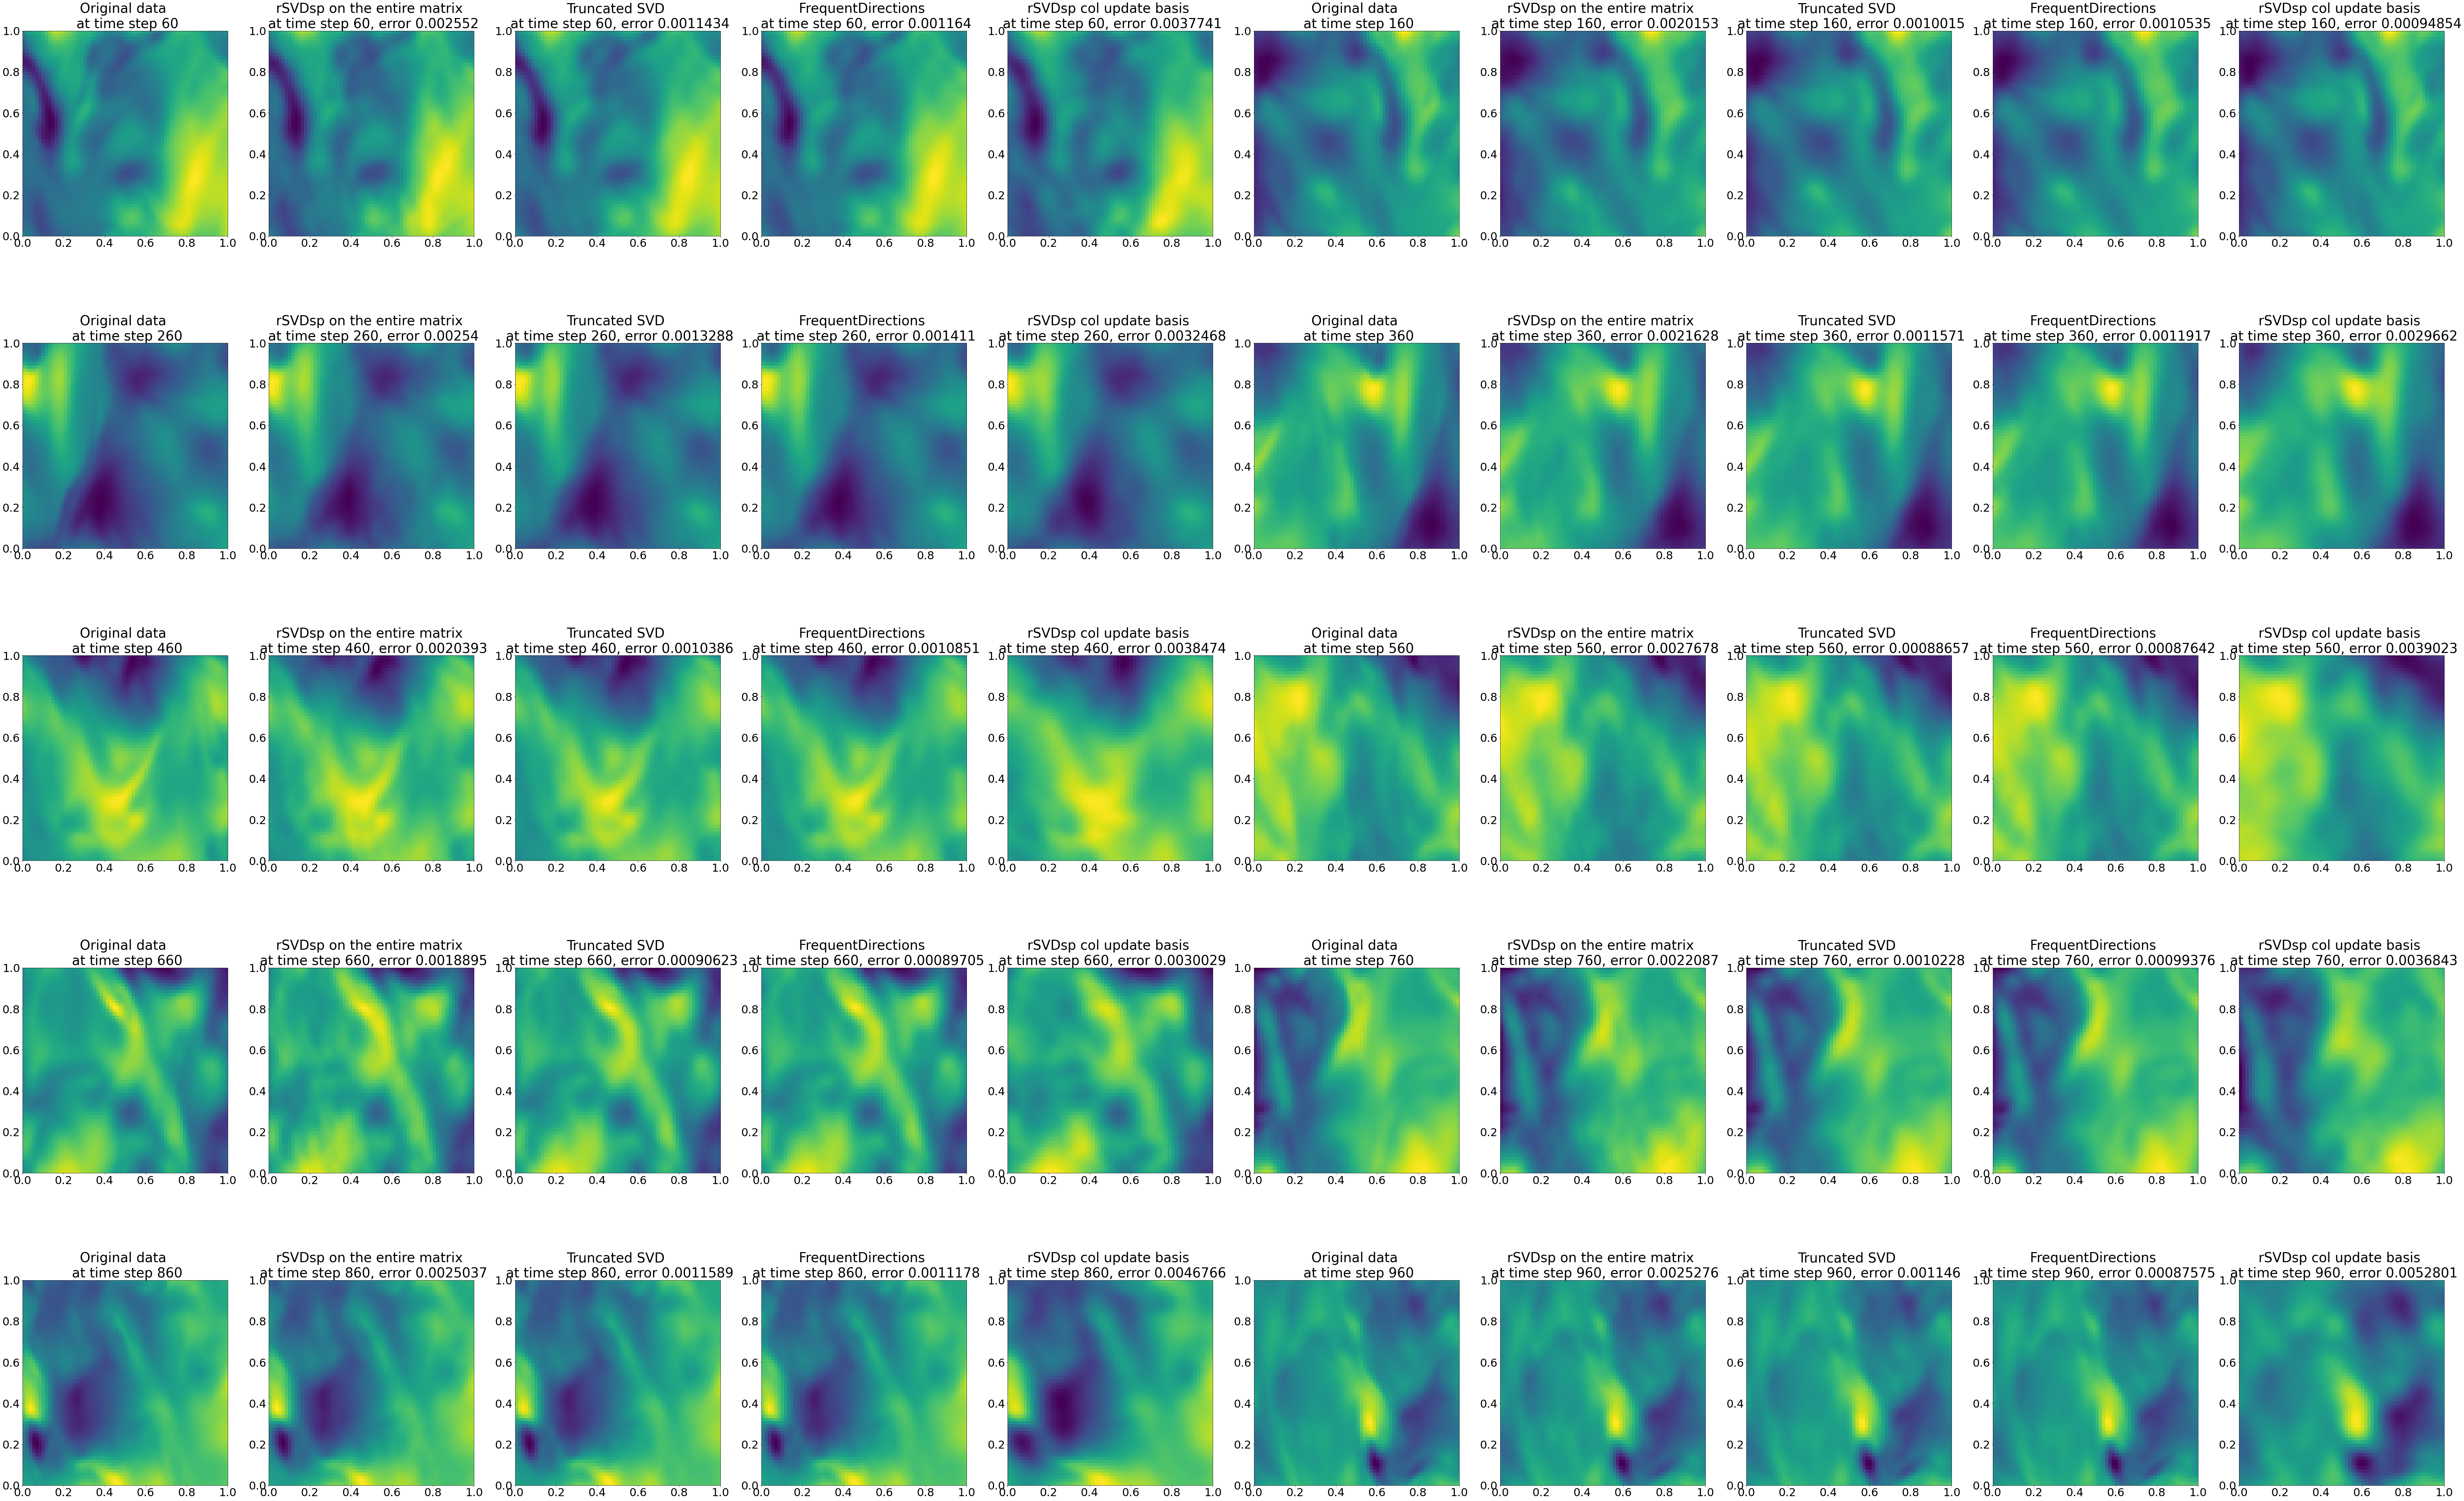

In [6]:

# ! Plot velocity Ux

t = np.linspace(0,1,nsample)
fig = plt.figure(figsize = (20, 5))

tstep_plot = 330

time_sample =np.linspace(60,960,10,dtype = int)

# for tstep_plot in time_sample:
#     # ! Original data
#     a = fig.add_subplot(141)
#     # a.set_axis_off()
#     a.set_title('Original data \n at time step {0}'.format(tstep_plot))
#     a.imshow(Ux[tstep_plot,:],
#             extent = [t[0], t[-1] - t[0], t[0], t[-1] - t[0]],
#             interpolation = 'none')

#     # ! Compress entire matrix
#     Ux_recon_entire_6464 = Ux_recon_entire.T.reshape([1001, 64, 64])

#     a = fig.add_subplot(142)

#     error_entire = np.linalg.norm(Ux[tstep_plot,:]-Ux_recon_entire_6464[tstep_plot,:],'fro')
#     a.set_title('Reconstructed data (rSVDsp on the entire matrix) \n at time step {0}, error {1:.5}'.format(tstep_plot, error_entire))
#     # a.set_axis_off()
#     a.imshow(Ux_recon_entire_6464[tstep_plot,:],
#             extent = [t[0], t[-1] - t[0], t[0], t[-1] - t[0]],
#             interpolation = 'none')

#     a = fig.add_subplot(143)
#     # a.set_axis_off()
#     error_block = np.linalg.norm(Ux[tstep_plot,:]-Ux_recon_block_6464[tstep_plot,:],'fro')

#     a.set_title('Reconstructed data (rSVDsp blocked version) \n at time step {0}, error {1:.5}'.format(tstep_plot,error_block))
#     a.imshow(Ux_recon_block_6464[tstep_plot,:],
#             extent = [t[0], t[-1] - t[0], t[0], t[-1] - t[0]],
#             interpolation = 'none')

#     plt.savefig('../test_JHTDB/Ux_k{0}_b{1}_t{2}.png'.format(dimReduced, blockSize, tstep_plot))

#     # ! Compress matrix blocked, updating basis 
#     Ux_recon_block_6464 = Ux_recon_block_update.T.reshape([1001, 64, 64])

#     a = fig.add_subplot(144)
#     # a.set_axis_off()
#     error_block = np.linalg.norm(Ux[tstep_plot,:]-Ux_recon_block_6464[tstep_plot,:],'fro')

#     a.set_title('Reconstructed data (rSVDsp blocked version) \n at time step {0}, error {1:.5}'.format(tstep_plot,error_block))
#     a.imshow(Ux_recon_block_6464[tstep_plot,:],
#             extent = [t[0], t[-1] - t[0], t[0], t[-1] - t[0]],
#             interpolation = 'none')

#     plt.savefig('../test_JHTDB/Ux_k{0}_b{1}_t{2}.png'.format(dimReduced, blockSize, tstep_plot))

num_row = 5
num_col = 2
num_case = 5
fig = plt.figure(figsize = (125, 80))
fig.patch.set_facecolor('white')
plt.rcParams.update({'font.size': 32})
for row in range(num_row):
    for col in range(num_col):
        tstep_plot = time_sample[col + row * num_col]
        for case in range(num_case):
            idx = row * num_col * num_case + col * num_case + case
            a_new = fig.add_subplot(num_row, num_col * num_case, idx + 1)
            if case == 0:
                
                a_new.set_title('Original data \n at time step {0}'.format(tstep_plot))
                plt.imshow(Ux[tstep_plot,:],
                        extent = [t[0], t[-1] - t[0], t[0], t[-1] - t[0]],
                        interpolation = 'none')
            elif case == 1: 
                # ! Compress entire matrix
                Ux_recon_entire_6464 = Ux_recon_entire.T.reshape([ntstep,nsample,nsample])

                error_entire = np.linalg.norm(Ux[tstep_plot,:]-Ux_recon_entire_6464[tstep_plot,:],'fro')
                error_relative = error_entire/np.linalg.norm(Ux[tstep_plot,:],'fro')
                a_new.set_title('rSVDsp on the entire matrix \n at time step {0}, error {1:.5}'.format(tstep_plot, error_relative))
                plt.imshow(Ux_recon_entire_6464[tstep_plot,:],
                        extent = [t[0], t[-1] - t[0], t[0], t[-1] - t[0]],
                        interpolation = 'none')
            elif case == 2:
                # ! Compress matrix blocked fix basis assemble 
                # Ux_recon_block_6464 = Ux_recon_block.T.reshape([ntstep,nsample,nsample])
                # error_block = np.linalg.norm(Ux[tstep_plot,:]-Ux_recon_block_6464[tstep_plot,:],'fro')
                # error_relative = error_block/np.linalg.norm(Ux[tstep_plot,:],'fro')
                # a_new.set_title('rSVDsp block fix basis \n at time step {0}, error {1:.5}'.format(tstep_plot,error_relative))
                # plt.imshow(Ux_recon_block_6464[tstep_plot,:],
                #         extent = [t[0], t[-1] - t[0], t[0], t[-1] - t[0]],
                #         interpolation = 'none')
                # ! Compress matrix partial SVD (rank)
                Ux_recon_rsvd_6464 = Ux_recon_rsvd.T.reshape([ntstep,nsample,nsample])
                error_block = np.linalg.norm(Ux[tstep_plot,:]-Ux_recon_rsvd_6464[tstep_plot,:],'fro')
                error_relative = error_block/np.linalg.norm(Ux[tstep_plot,:],'fro')
                a_new.set_title('Truncated SVD \n at time step {0}, error {1:.5}'.format(tstep_plot,error_relative))
                plt.imshow(Ux_recon_rsvd_6464[tstep_plot,:],
                        extent = [t[0], t[-1] - t[0], t[0], t[-1] - t[0]],
                        interpolation = 'none')
            elif case == 3:
                # ! Compress matrix frequent directions
                Ux_recon_fd_6464 = Ux_recon_fd.T.reshape([ntstep,nsample,nsample])
                error_fd = np.linalg.norm(Ux[tstep_plot,:]-Ux_recon_fd_6464[tstep_plot,:],'fro')
                error_relative = error_fd/np.linalg.norm(Ux[tstep_plot,:],'fro')
                a_new.set_title('FrequentDirections \n at time step {0}, error {1:.5}'.format(tstep_plot,error_relative))
                plt.imshow(Ux_recon_fd_6464[tstep_plot,:],
                        extent = [t[0], t[-1] - t[0], t[0], t[-1] - t[0]],
                        interpolation = 'none')                
            else:
                # ! Compress matrix blocked, updating basis col by col 
                Ux_recon_col_6464 = Ux_recon_col_update.T.reshape([ntstep,nsample,nsample])
                error_col = np.linalg.norm(Ux[tstep_plot,:]-Ux_recon_col_6464[tstep_plot,:],'fro')
                error_relative = error_col/np.linalg.norm(Ux[tstep_plot,:],'fro')
                a_new.set_title('rSVDsp col update basis \n at time step {0}, error {1:.5}'.format(tstep_plot,error_relative))
                plt.imshow(Ux_recon_col_6464[tstep_plot,:],
                        extent = [t[0], t[-1] - t[0], t[0], t[-1] - t[0]],
                        interpolation = 'none')
                # # ! Compress matrix blocked, updating basis 
                # Ux_recon_block_6464 = Ux_recon_block_update.T.reshape([1000, 64, 64])
                # error_block = np.linalg.norm(Ux[tstep_plot,:]-Ux_recon_block_6464[tstep_plot,:],'fro')
                # error_relative = error_block/np.linalg.norm(Ux[tstep_plot,:],'fro')
                # a_new.set_title('rSVDsp block update basis \n at time step {0}, error {1:.5}'.format(tstep_plot,error_relative))
                # plt.imshow(Ux_recon_block_6464[tstep_plot,:],
                #         extent = [t[0], t[-1] - t[0], t[0], t[-1] - t[0]],
                #         interpolation = 'none')
plt.show()
fig.savefig('../test_JHTDB/Ux_k{0}_b{1}_ns{2}_accuracy_verify.png'.format(dimReduced, blockSize,nsample))

# A_struct = sio.loadmat('../test_mat2/A4.mat')
# A = A_struct['A4']

# # ! Load results from Yu et al's peper
# U2_struct = sio.loadmat('../test_mat2/u_sp_A4.mat')
# U2 = U2_struct['u_sp_A4']
# D2_struct = sio.loadmat('../test_mat2/d_sp_A4.mat')
# D2 = D2_struct['d_sp_A4']
# V2_struct = sio.loadmat('../test_mat2/v_sp_A4.mat')
# V2 = V2_struct['v_sp_A4']

# dimReduced = 50


# # ! Benchmark SVD result
# U, S, V = np.linalg.svd(A)
# tmp_size = np.shape(S)[0]
# tmp_S_mat = np.zeros((tmp_size, tmp_size))
# np.fill_diagonal(tmp_S_mat,S)
# norm_f_svd = np.linalg.norm(A-U@tmp_S_mat@V, 'fro')
# print('Benchmark SVD:', norm_f_svd)



<Figure size 1440x360 with 0 Axes>

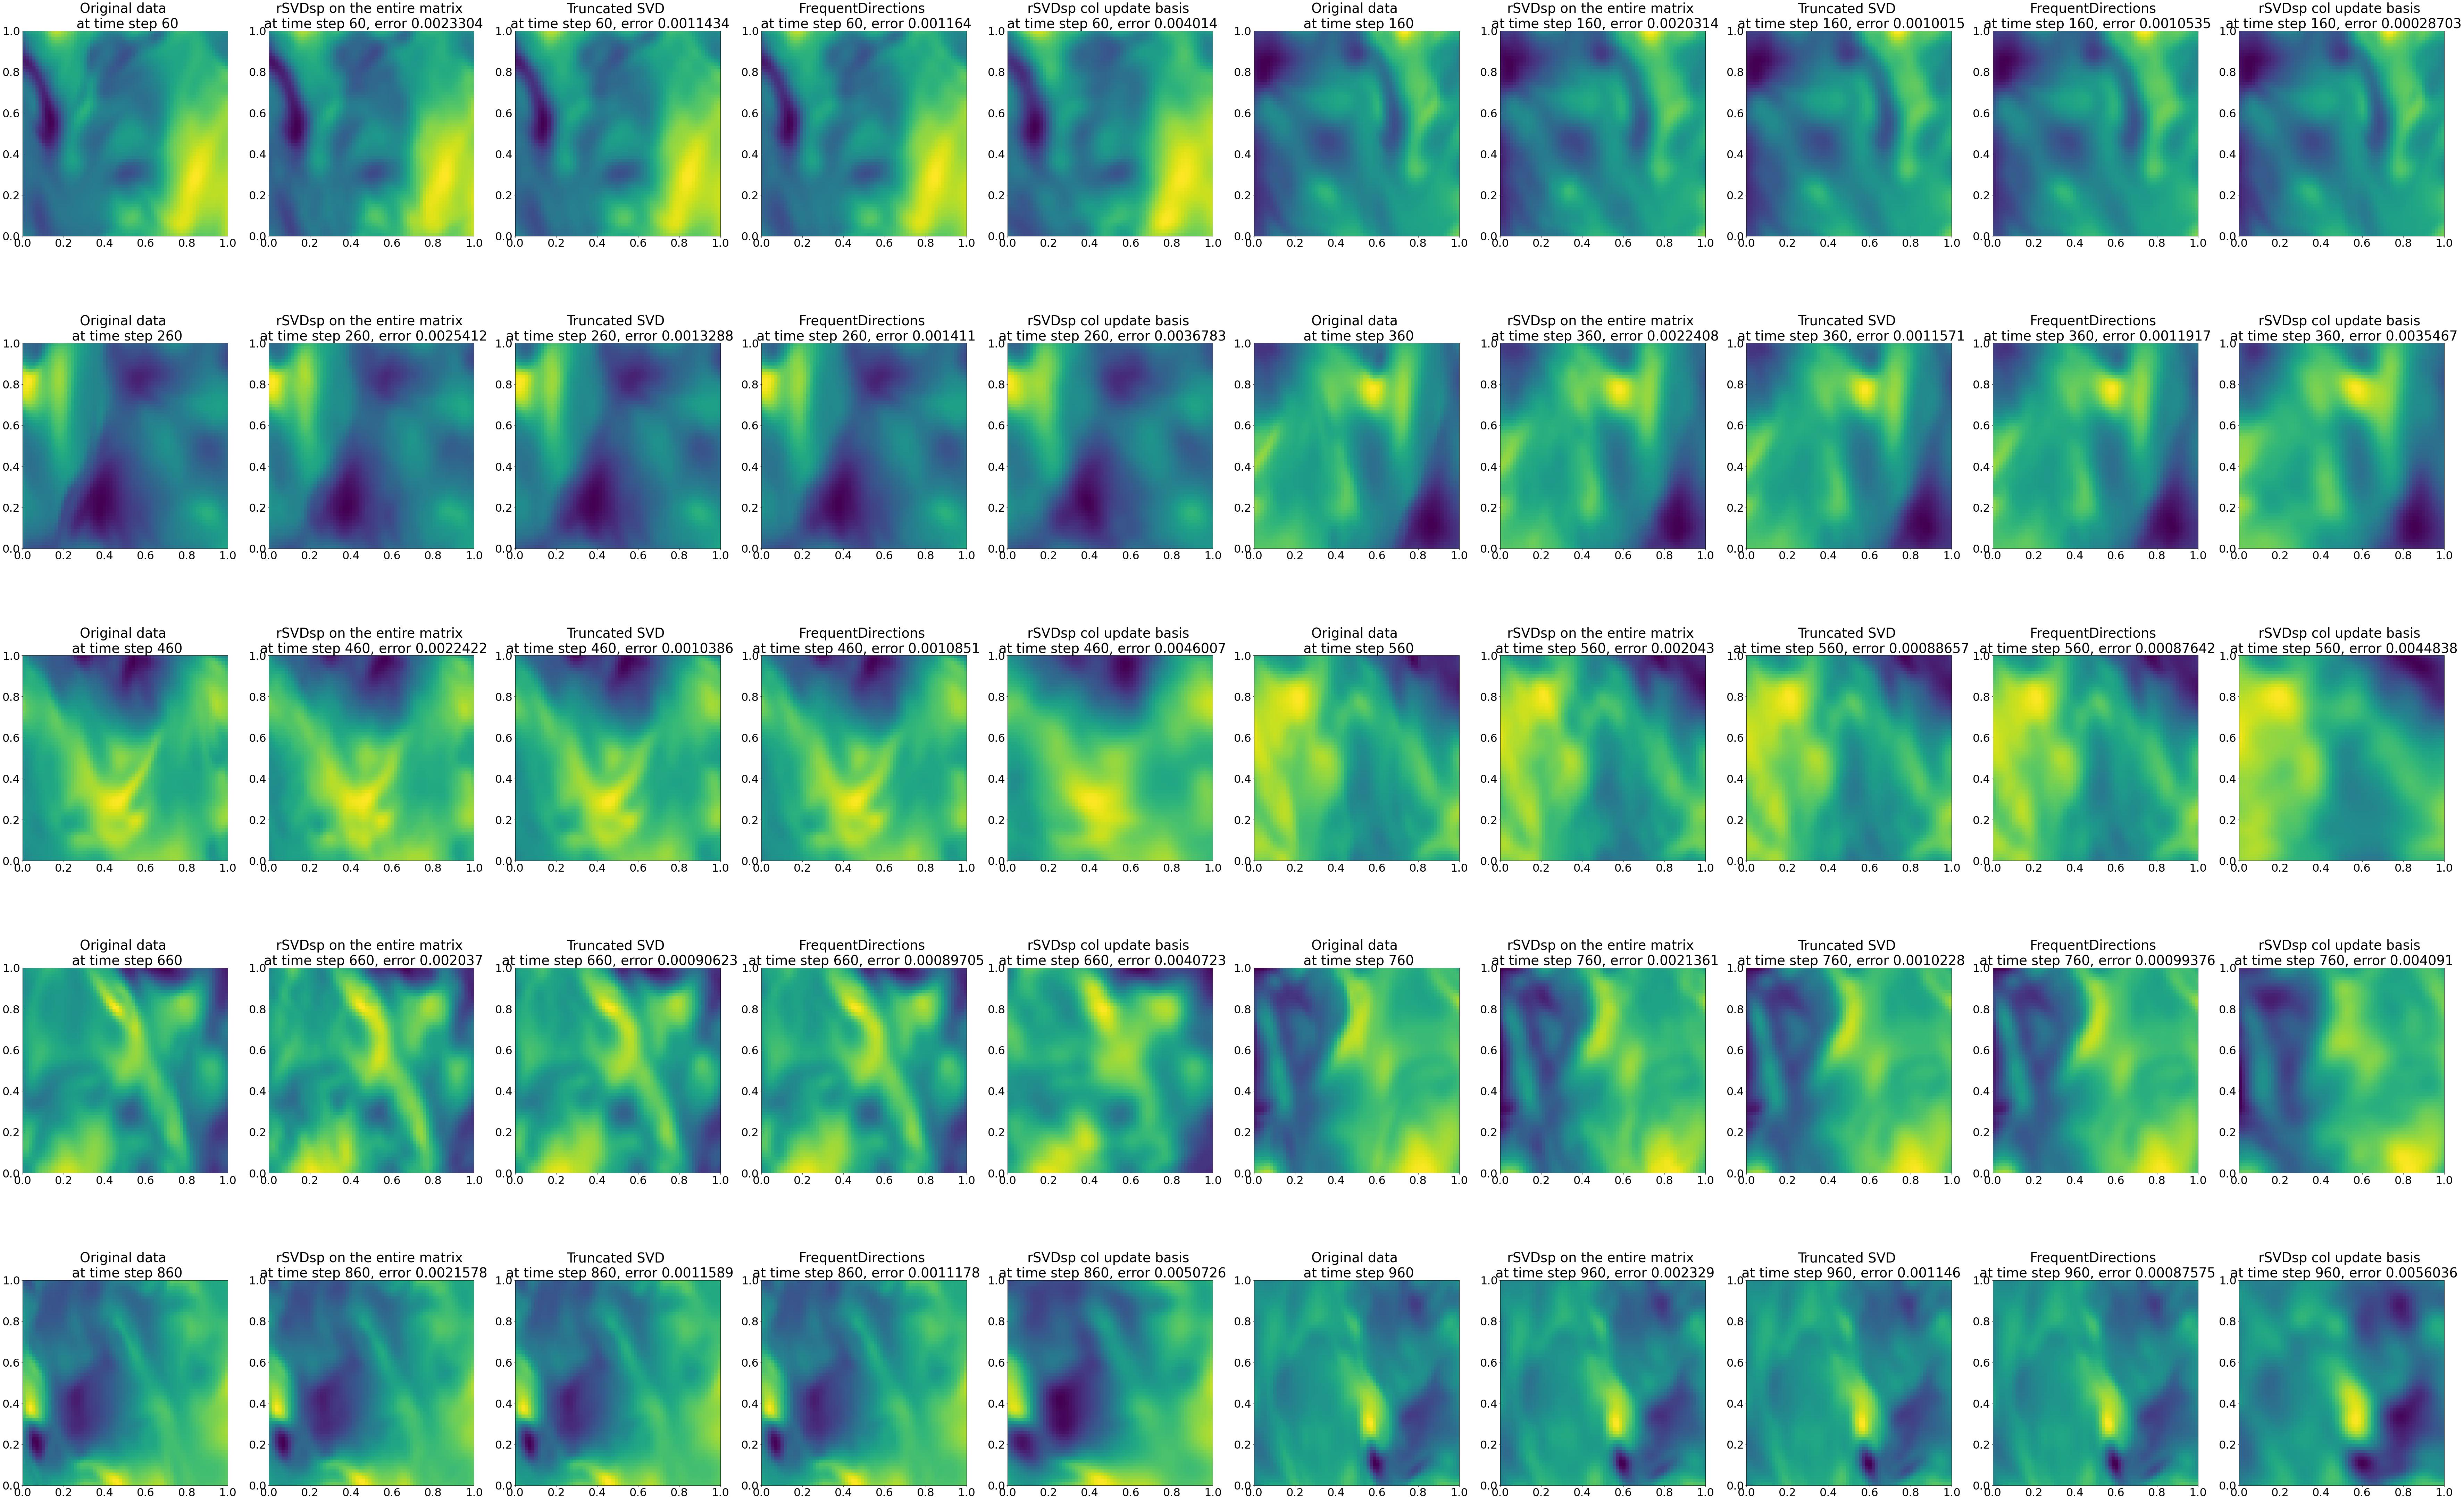

In [10]:

# ! Plot velocity Ux

t = np.linspace(0,1,64)
fig = plt.figure(figsize = (20, 5))

tstep_plot = 330

time_sample =np.linspace(60,960,10,dtype = int)

# for tstep_plot in time_sample:
#     # ! Original data
#     a = fig.add_subplot(141)
#     # a.set_axis_off()
#     a.set_title('Original data \n at time step {0}'.format(tstep_plot))
#     a.imshow(Ux[tstep_plot,:],
#             extent = [t[0], t[-1] - t[0], t[0], t[-1] - t[0]],
#             interpolation = 'none')

#     # ! Compress entire matrix
#     Ux_recon_entire_6464 = Ux_recon_entire.T.reshape([1001, 64, 64])

#     a = fig.add_subplot(142)

#     error_entire = np.linalg.norm(Ux[tstep_plot,:]-Ux_recon_entire_6464[tstep_plot,:],'fro')
#     a.set_title('Reconstructed data (rSVDsp on the entire matrix) \n at time step {0}, error {1:.5}'.format(tstep_plot, error_entire))
#     # a.set_axis_off()
#     a.imshow(Ux_recon_entire_6464[tstep_plot,:],
#             extent = [t[0], t[-1] - t[0], t[0], t[-1] - t[0]],
#             interpolation = 'none')

#     # ! Compress matrix blocked fix basisassemble 
#     Ux_recon_block_6464 = Ux_recon_block.T.reshape([1001, 64, 64])

#     a = fig.add_subplot(143)
#     # a.set_axis_off()
#     error_block = np.linalg.norm(Ux[tstep_plot,:]-Ux_recon_block_6464[tstep_plot,:],'fro')

#     a.set_title('Reconstructed data (rSVDsp blocked version) \n at time step {0}, error {1:.5}'.format(tstep_plot,error_block))
#     a.imshow(Ux_recon_block_6464[tstep_plot,:],
#             extent = [t[0], t[-1] - t[0], t[0], t[-1] - t[0]],
#             interpolation = 'none')

#     plt.savefig('../test_JHTDB/Ux_k{0}_b{1}_t{2}.png'.format(dimReduced, blockSize, tstep_plot))

#     # ! Compress matrix blocked, updating basis 
#     Ux_recon_block_6464 = Ux_recon_block_update.T.reshape([1001, 64, 64])

#     a = fig.add_subplot(144)
#     # a.set_axis_off()
#     error_block = np.linalg.norm(Ux[tstep_plot,:]-Ux_recon_block_6464[tstep_plot,:],'fro')

#     a.set_title('Reconstructed data (rSVDsp blocked version) \n at time step {0}, error {1:.5}'.format(tstep_plot,error_block))
#     a.imshow(Ux_recon_block_6464[tstep_plot,:],
#             extent = [t[0], t[-1] - t[0], t[0], t[-1] - t[0]],
#             interpolation = 'none')

#     plt.savefig('../test_JHTDB/Ux_k{0}_b{1}_t{2}.png'.format(dimReduced, blockSize, tstep_plot))

num_row = 5
num_col = 2
num_case = 5
fig = plt.figure(figsize = (125, 80))
fig.patch.set_facecolor('white')
plt.rcParams.update({'font.size': 32})
for row in range(num_row):
    for col in range(num_col):
        tstep_plot = time_sample[col + row * num_col]
        for case in range(num_case):
            idx = row * num_col * num_case + col * num_case + case
            a_new = fig.add_subplot(num_row, num_col * num_case, idx + 1)
            if case == 0:
                
                a_new.set_title('Original data \n at time step {0}'.format(tstep_plot))
                plt.imshow(Ux[tstep_plot,:],
                        extent = [t[0], t[-1] - t[0], t[0], t[-1] - t[0]],
                        interpolation = 'none')
            elif case == 1: 
                # ! Compress entire matrix
                Ux_recon_entire_6464 = Ux_recon_entire.T.reshape([1000, 64, 64])

                error_entire = np.linalg.norm(Ux[tstep_plot,:]-Ux_recon_entire_6464[tstep_plot,:],'fro')
                error_relative = error_entire/np.linalg.norm(Ux[tstep_plot,:],'fro')
                a_new.set_title('rSVDsp on the entire matrix \n at time step {0}, error {1:.5}'.format(tstep_plot, error_relative))
                plt.imshow(Ux_recon_entire_6464[tstep_plot,:],
                        extent = [t[0], t[-1] - t[0], t[0], t[-1] - t[0]],
                        interpolation = 'none')
            elif case == 2:
                # ! Compress matrix blocked fix basis assemble 
                # Ux_recon_block_6464 = Ux_recon_block.T.reshape([1000, 64, 64])
                # error_block = np.linalg.norm(Ux[tstep_plot,:]-Ux_recon_block_6464[tstep_plot,:],'fro')
                # error_relative = error_block/np.linalg.norm(Ux[tstep_plot,:],'fro')
                # a_new.set_title('rSVDsp block fix basis \n at time step {0}, error {1:.5}'.format(tstep_plot,error_relative))
                # plt.imshow(Ux_recon_block_6464[tstep_plot,:],
                #         extent = [t[0], t[-1] - t[0], t[0], t[-1] - t[0]],
                #         interpolation = 'none')
                # ! Compress matrix partial SVD (rank)
                Ux_recon_rsvd_6464 = Ux_recon_rsvd.T.reshape([1000, 64, 64])
                error_block = np.linalg.norm(Ux[tstep_plot,:]-Ux_recon_rsvd_6464[tstep_plot,:],'fro')
                error_relative = error_block/np.linalg.norm(Ux[tstep_plot,:],'fro')
                a_new.set_title('Truncated SVD \n at time step {0}, error {1:.5}'.format(tstep_plot,error_relative))
                plt.imshow(Ux_recon_rsvd_6464[tstep_plot,:],
                        extent = [t[0], t[-1] - t[0], t[0], t[-1] - t[0]],
                        interpolation = 'none')
            elif case == 3:
                # ! Compress matrix frequent directions
                Ux_recon_fd_6464 = Ux_recon_fd.T.reshape([1000, 64, 64])
                error_fd = np.linalg.norm(Ux[tstep_plot,:]-Ux_recon_fd_6464[tstep_plot,:],'fro')
                error_relative = error_fd/np.linalg.norm(Ux[tstep_plot,:],'fro')
                a_new.set_title('FrequentDirections \n at time step {0}, error {1:.5}'.format(tstep_plot,error_relative))
                plt.imshow(Ux_recon_fd_6464[tstep_plot,:],
                        extent = [t[0], t[-1] - t[0], t[0], t[-1] - t[0]],
                        interpolation = 'none')                
            else:
                # ! Compress matrix blocked, updating basis col by col 
                Ux_recon_col_6464 = Ux_recon_col_update.T.reshape([1000, 64, 64])
                error_col = np.linalg.norm(Ux[tstep_plot,:]-Ux_recon_col_6464[tstep_plot,:],'fro')
                error_relative = error_col/np.linalg.norm(Ux[tstep_plot,:],'fro')
                a_new.set_title('rSVDsp col update basis \n at time step {0}, error {1:.5}'.format(tstep_plot,error_relative))
                plt.imshow(Ux_recon_col_6464[tstep_plot,:],
                        extent = [t[0], t[-1] - t[0], t[0], t[-1] - t[0]],
                        interpolation = 'none')
                # # ! Compress matrix blocked, updating basis 
                # Ux_recon_block_6464 = Ux_recon_block_update.T.reshape([1000, 64, 64])
                # error_block = np.linalg.norm(Ux[tstep_plot,:]-Ux_recon_block_6464[tstep_plot,:],'fro')
                # error_relative = error_block/np.linalg.norm(Ux[tstep_plot,:],'fro')
                # a_new.set_title('rSVDsp block update basis \n at time step {0}, error {1:.5}'.format(tstep_plot,error_relative))
                # plt.imshow(Ux_recon_block_6464[tstep_plot,:],
                #         extent = [t[0], t[-1] - t[0], t[0], t[-1] - t[0]],
                #         interpolation = 'none')
plt.show()
fig.savefig('../test_JHTDB/Ux_k{0}_b{1}_accuracy_verify.png'.format(dimReduced, blockSize))

# A_struct = sio.loadmat('../test_mat2/A4.mat')
# A = A_struct['A4']

# # ! Load results from Yu et al's peper
# U2_struct = sio.loadmat('../test_mat2/u_sp_A4.mat')
# U2 = U2_struct['u_sp_A4']
# D2_struct = sio.loadmat('../test_mat2/d_sp_A4.mat')
# D2 = D2_struct['d_sp_A4']
# V2_struct = sio.loadmat('../test_mat2/v_sp_A4.mat')
# V2 = V2_struct['v_sp_A4']

# dimReduced = 50


# # ! Benchmark SVD result
# U, S, V = np.linalg.svd(A)
# tmp_size = np.shape(S)[0]
# tmp_S_mat = np.zeros((tmp_size, tmp_size))
# np.fill_diagonal(tmp_S_mat,S)
# norm_f_svd = np.linalg.norm(A-U@tmp_S_mat@V, 'fro')
# print('Benchmark SVD:', norm_f_svd)

